# Progetto Time Series Galimberti e Rinaldi

Importo i pacchetti necessari e una funzione che servirà in seguito

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import numpy as np
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox



In [3]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    """Using an ADF test to determine if a series is stationary"""
    test_results = adfuller(series)
    print('ADF Statistic: ', test_results[0])
    print('P-Value: ', test_results[1])
    print('Critical Values:')
    for thres, adf_stat in test_results[4].items():
        print('\t%s: %.2f' % (thres, adf_stat))

**Presentazione del dataset**

Il dataset che presentiamo è _ice cream_ ed è disponibile al seguente link: https://www.kaggle.com/datasets/abdocan/monthly-ice-cream-sales-data-1972-2020

Questo Dataset raccoglie le vendite di gelato.
Include 577 righe che rappresentano le vendite mensili di gelato dal 1972 al 2020 e presenta 2 colonne.

Le features presenti sono:
* Date: la data in esame
* IPN31152N: rappresenta la vendita mensile dei gelati

**Importo il Dataset**

In [4]:
df= pd.read_csv("ice_cream.csv")
df.head(10)

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636
5,1972-06-01,100.5960
6,1972-07-01,100.1263
7,1972-08-01,96.3607
8,1972-09-01,85.8007
9,1972-10-01,70.3934


In [5]:
print(df.columns)
print(df.dtypes)
print(len(df))
df['DATE'] = pd.to_datetime(df['DATE']) 

Index(['DATE', 'IPN31152N'], dtype='object')
DATE          object
IPN31152N    float64
dtype: object
577


Text(0, 0.5, 'Ice Cream Sales')

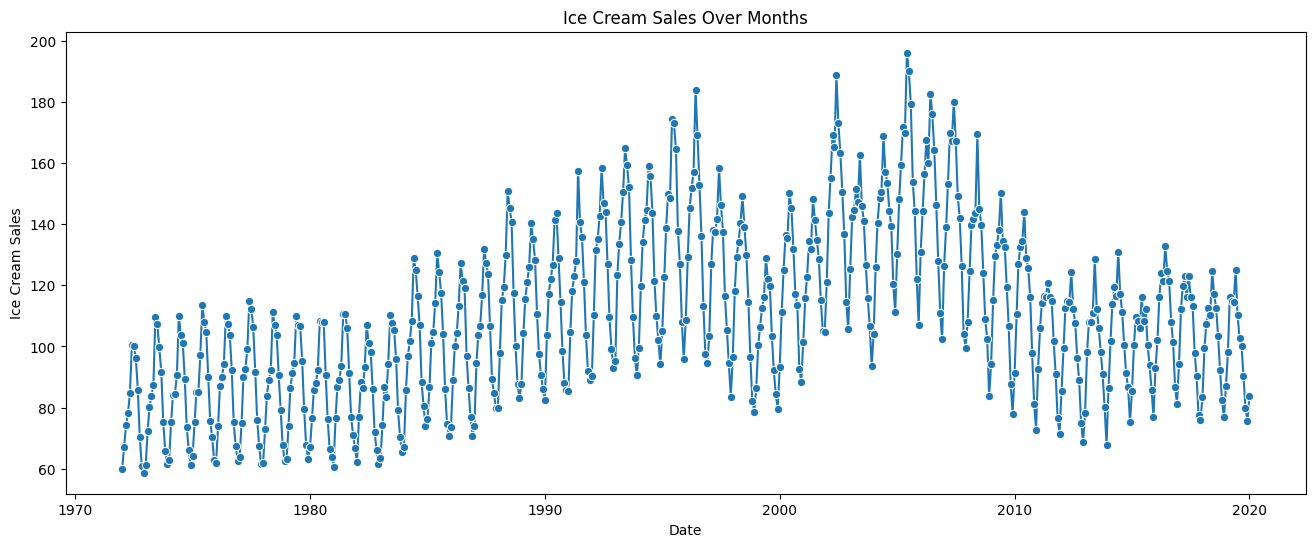

In [6]:
plt.figure(figsize=(16, 6))
sns.lineplot(data = df, x='DATE', y= 'IPN31152N', marker='o')
plt.title('Ice Cream Sales Over Months')
plt.xlabel('Date')
plt.ylabel('Ice Cream Sales')


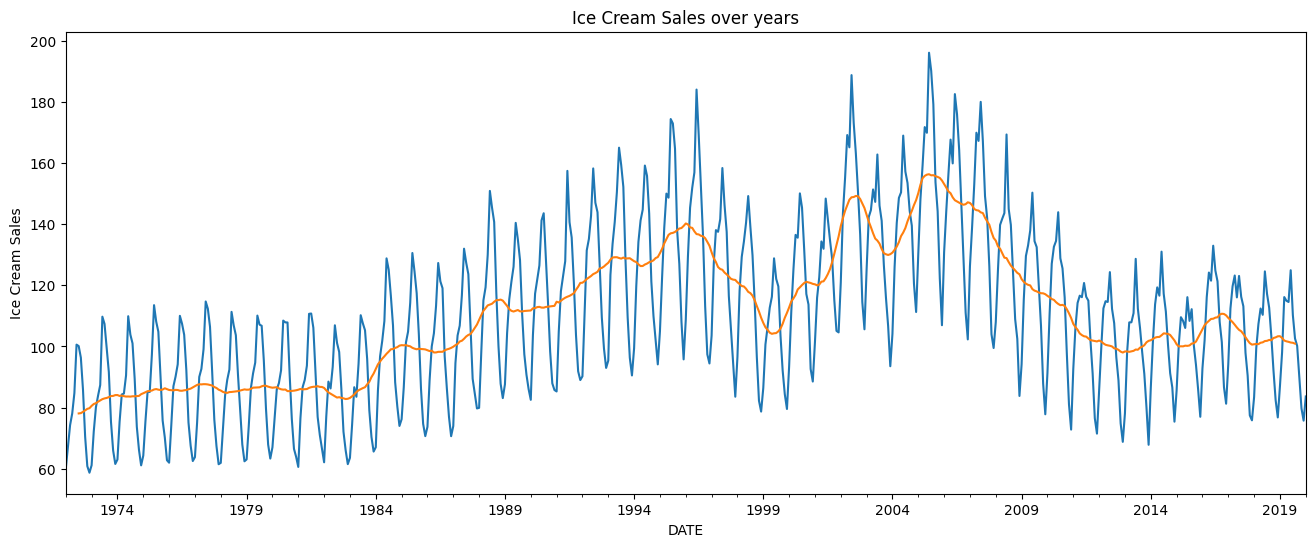

In [15]:
df0=df.copy()
plt.figure(figsize=(16, 6))
df0.set_index('DATE',inplace=True)
plt.ylabel('Ice Cream Sales')
plt.title('Ice Cream Sales over years')

df0['IPN31152N'].plot()
df0['IPN31152N'].rolling(12,center=True).mean().plot()
plt.show()

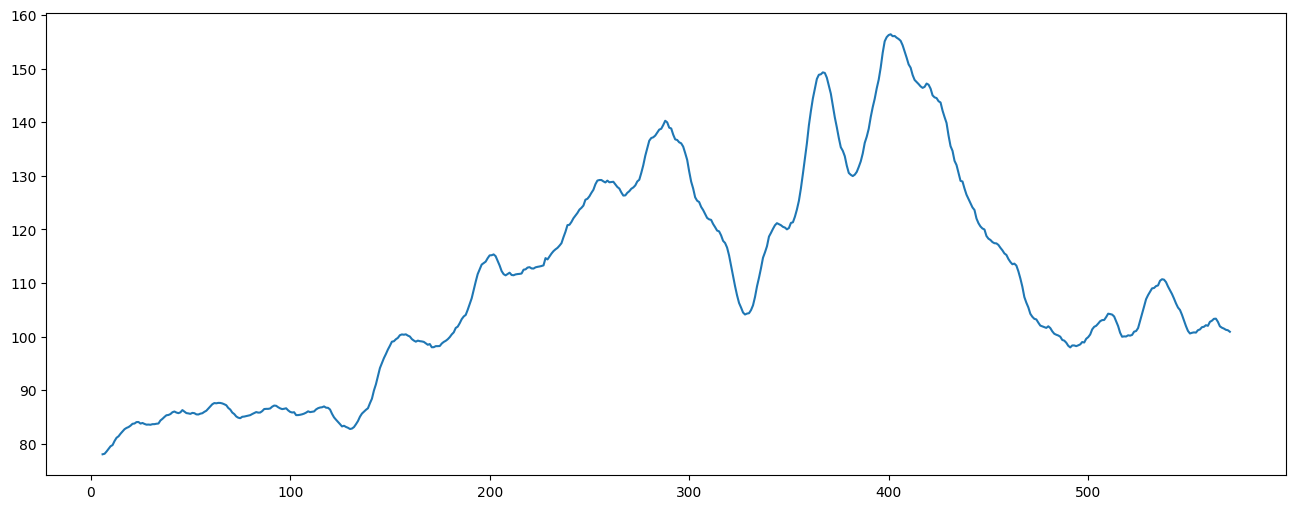

In [8]:
plt.figure(figsize=(16, 6))
df['IPN31152N'].rolling(12,center=True).mean().plot() 
plt.show()

Notiamo una periodicità nell'andamento delle vendite di tipo annuale (perchè i punti più in basso corrispondono all'anno) e un andamento di tipo polinomiale con noise moltiplicativo. Queste assunzioni verranno poi confermate nelle successive analisi.

Essendo un modello di tipo moltiplicativo applichiamo la log trasformation per regolarizzare il noise

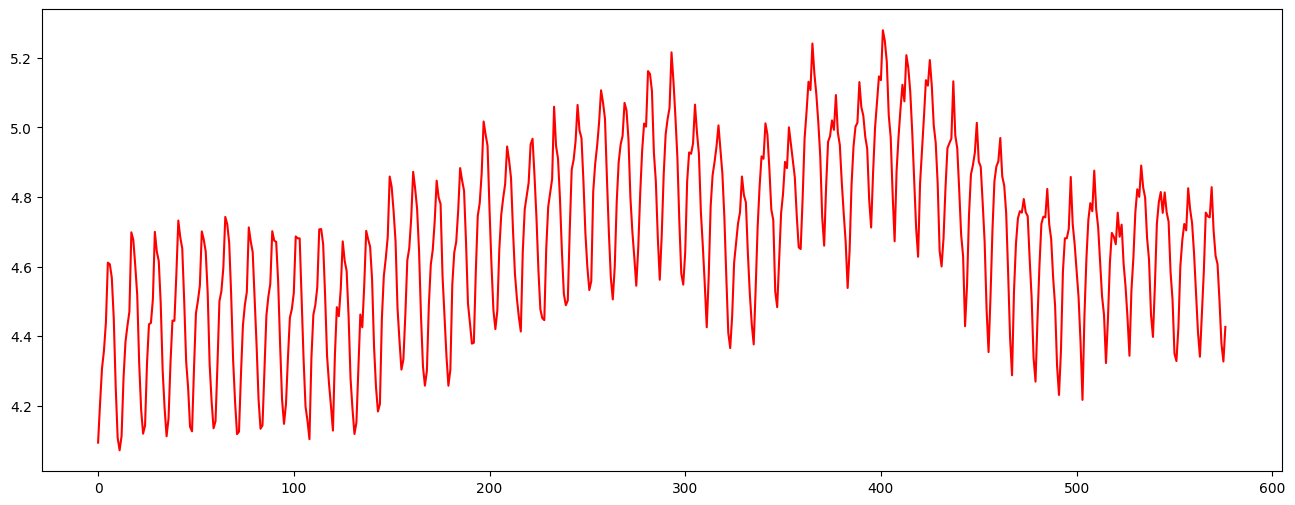

<Figure size 1600x600 with 0 Axes>

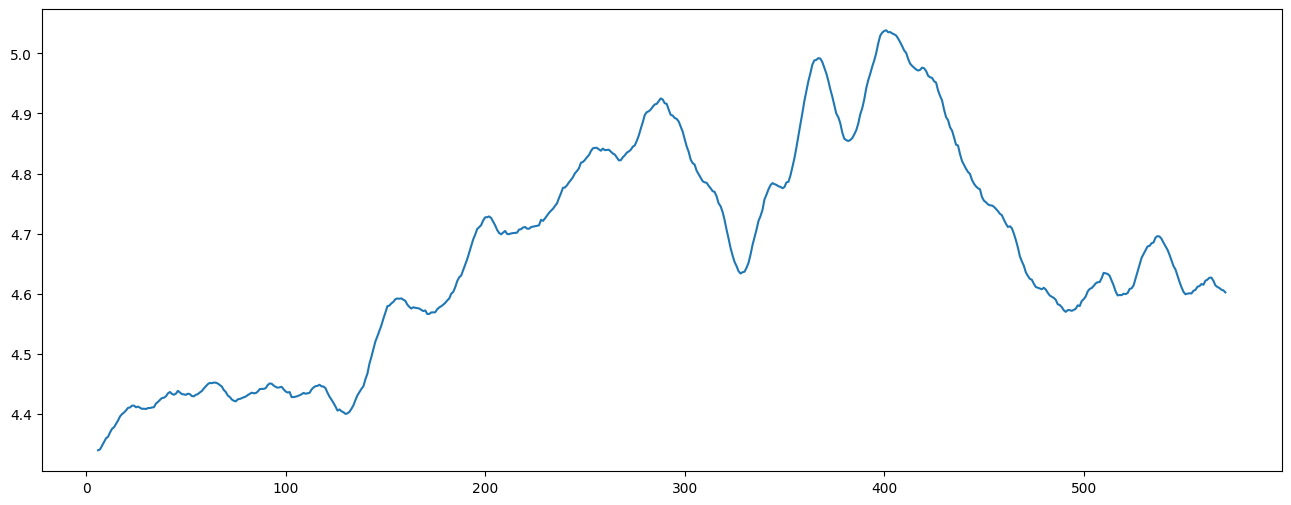

In [16]:
df['log_IPN31152N']=np.log(df['IPN31152N']) 
plt.figure(figsize=(16, 6))
df['log_IPN31152N'].plot( color = 'red')
plt.figure(figsize=(16, 6))
plt.show()
plt.figure(figsize=(16, 6))
df['log_IPN31152N'].rolling(12,center=True).mean().plot() 
plt.show()

la verifichiamo anche graficamente

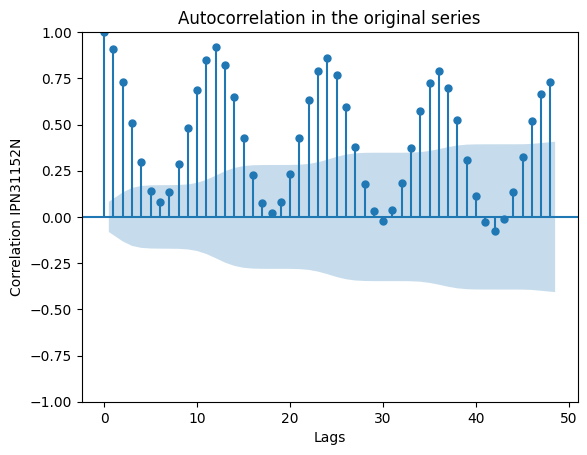

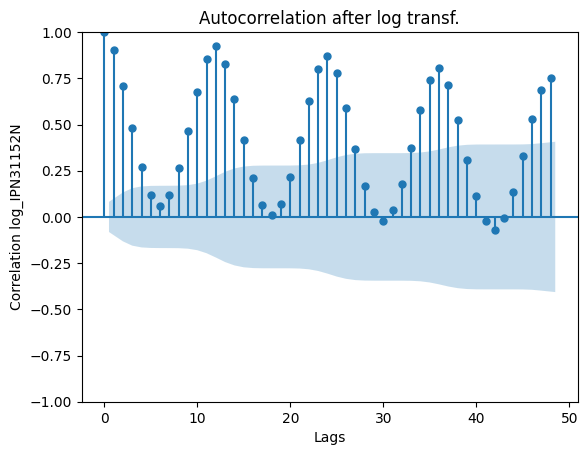

In [10]:
plot_acf(df['IPN31152N'],lags=48)
plt.ylabel('Correlation IPN31152N')
plt.xlabel('Lags')
plt.title('Autocorrelation in the original series')
plt.show()

plot_acf(df['log_IPN31152N'].dropna(),lags=48)
plt.ylabel('Correlation log_IPN31152N')
plt.xlabel('Lags')
plt.title('Autocorrelation after log transf.')
plt.show()



Questi grafici confermano che la perdiodicità è di 12 mesi

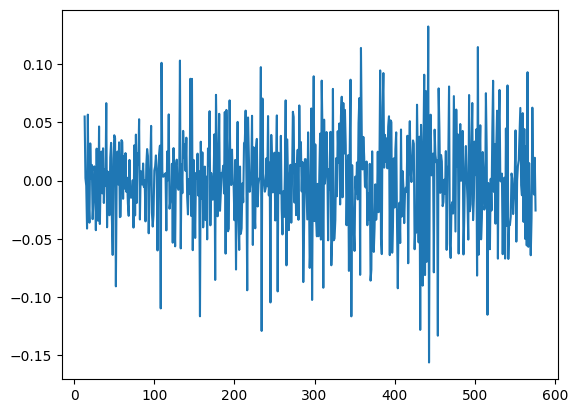

ADF Statistic:  -10.34669768310381
P-Value:  2.5997888527279992e-18
Critical Values:
	1%: -3.44
	5%: -2.87
	10%: -2.57


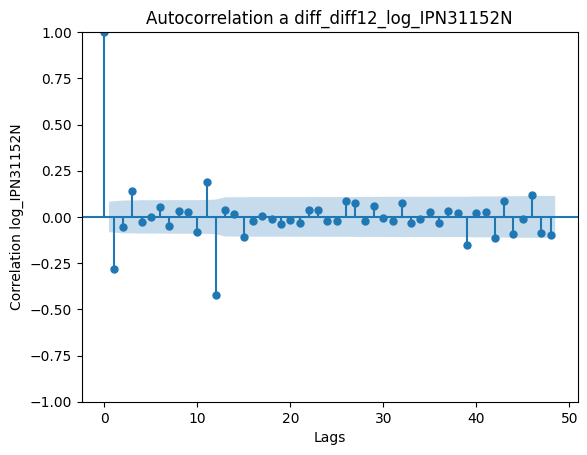

      lb_stat     lb_pvalue
1   44.264388  2.868881e-11
2   46.066802  9.924784e-11
3   56.933664  2.655053e-12
4   57.439018  1.000731e-11
5   57.439199  4.105320e-11
6   59.169542  6.636540e-11
7   60.474980  1.213337e-10
8   61.035947  2.917920e-10
9   61.392875  7.220154e-10
10  65.325882  3.511147e-10



In [11]:
df['diff_diff12_log_IPN31152N']=np.log(df['IPN31152N']).diff(12).diff(1)
df['diff_diff12_log_IPN31152N'].plot()
plt.xlabel('')
plt.show()

adf_test(df['diff_diff12_log_IPN31152N'].dropna())
plot_acf(df['diff_diff12_log_IPN31152N'].dropna(),lags=48)
plt.ylabel('Correlation log_IPN31152N')
plt.xlabel('Lags')
plt.title('Autocorrelation a diff_diff12_log_IPN31152N')
plt.show()
print(acorr_ljungbox(df['diff_diff12_log_IPN31152N'].dropna(), return_df=True))
print()

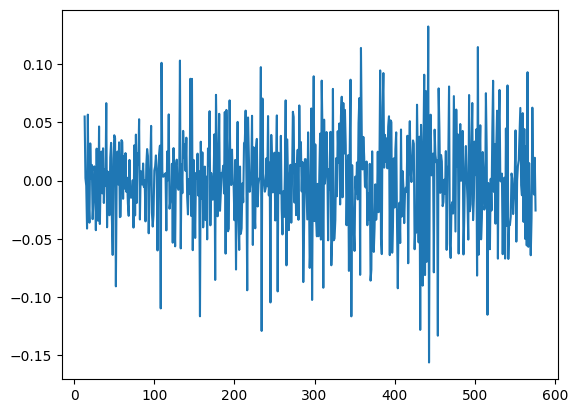

In [18]:
df['diff_diff12_log_IPN31152N'].plot()
plt.show()

Poichè il valore di adf è molto minore della significatività allora possiamo rifiutare l'ipotesi nulla (cioè rifiutiamo che la serie non è stazionaria) quindi la serie è stazionaria

# Previsione


In [13]:
0.15*len(df) # voglio 15% dei dati per il test

86.55

Abbiamo deciso di effettuare la predizione sul 15% del dataset che corrisponde agli ultimi 7 anni di valori di vendite mensili

In [14]:
# Train-test split
train = df.iloc[:-86]
test = df.iloc[-86:]

# AR model order selection
selector = ar_select_order(train['diff_diff12_log_IPN31152N'].dropna(), maxlag=12)
print(f"Selected AR lags: {selector.ar_lags}")

# Fit the AR model
model = AutoReg(
    train['diff_diff12_log_IPN31152N'].dropna(), 
    lags=selector.ar_lags
).fit()

# Forecast differenced values
diff_forecasts = list(model.forecast(steps=len(test)))

# Step 1: Undo regular differencing
seasonal_diff_forecasts = []
last_seasonal_diff = train['diff_diff12_log_IPN31152N'].iloc[-1]
for i, diff_forecast in enumerate(diff_forecasts):
    if i == 0:
        val = diff_forecast + last_seasonal_diff
    else:
        val = diff_forecast + seasonal_diff_forecasts[i - 1]
    seasonal_diff_forecasts.append(val)

# Step 2: Undo seasonal differencing
log_forecasts = []
log_series = train['log_IPN31152N']

for i, val in enumerate(seasonal_diff_forecasts):
    if i < 12:
        restored = val + log_series.iloc[-12 + i]
    else:
        restored = val + log_forecasts[i - 12]
    log_forecasts.append(restored)

# Step 3: Undo log transformation
forecasts = np.exp(log_forecasts)
forecasts = pd.Series(forecasts, index=test.index)
def plot_forecasts(forecasts, title):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train['IPN31152N'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=test['IPN31152N'], name='Test'))
    fig.add_trace(go.Scatter(x=test.index, y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')
    return fig.show()

plot_forecasts(forecasts, 'Autoregression Forecast')

mean_abs_err=(np.abs(forecasts-test['IPN31152N'])/test['IPN31152N']).mean()
print(f'Mean absolute error: {mean_abs_err}')


c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at

Selected AR lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Mean absolute error: 0.09751310579465727


Il modello regressivo è soddisfacente avendo un percentale di discostamento dai dati originali di meno del 10%.